# Hakai Nutrient QA-QC 
---
# Start Notebook
## Install packages 
Google colab servers has already a few commonly used packages installed. To install those missing, which are specific toh Hakai let's run the following commands:

In [ ]:
!pip install hakai-api
!pip install git+git://github.com/HakaiInstitute/ioos_qc.git@development

  Cloning git://github.com/HakaiInstitute/ioos_qc.git (to revision development) to /tmp/pip-req-build-he_bqdh6
  Running command git clone -q git://github.com/HakaiInstitute/ioos_qc.git /tmp/pip-req-build-he_bqdh6
  Running command git checkout -b development --track origin/development
  Switched to a new branch 'development'
  Branch 'development' set up to track remote branch 'development' from 'origin'.
     |████████████████████████████████| 1.0MB 10.6MB/s 
     |████████████████████████████████| 4.7MB 30.1MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 133kB 45.6MB/s 
     |████████████████████████████████| 15.3MB 175kB/s 
     |████████████████████████████████| 6.5MB 51.8MB/s 
     |████████████████████████████████| 317kB 56.7MB/s 
     |████████████████████████████████| 552kB 52.6MB/s 
  Created wheel for ioos-qc: filename=ioos_qc-1.0.0-cp37-none-any.whl size=44499 sha256=96bf8d649001d812c353e33c7a2dc80214b7494cc1c8bce2b0c0b3d

## Import the python packages needed

In [ ]:
# Let's load pandas for working with the data in table
import pandas as pd 
import numpy as np
# Let's load seaborn to plot the data
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# This to install the hakai api tool and be able to download some data from hakai's database
from hakai_api import Client

# Install ioos_qc which is used to qc data
from ioos_qc.config import QcConfig
from ioos_qc import qartod

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Download data from the Hakai database
For more information regarding the Hakai API, go [here](https://github.com/HakaiInstitute/hakai-api).

You can find a list of all the data type endpoints [here](http://hakaiinstitute.github.io/hakai-api/#endpoints).

In [ ]:
# Let's first define the QARTOD flag colors to use
qartod_colors={1:'#2ECC40', 2:'#FFDC00', 3:'#FF851B', 4:'#FF4136', 9:'#85144b'}
qartod_colors_str = {"{0}".format(key):value for key,value in qartod_colors.items()}

# And the interesting variables to use from the Hakai database
nutrient_variables = ['no2_no3_um','sio2','po4']

In [ ]:
# Let's retrieve the endpoint to retrieve nutrients data:
endpointUrl = '/eims/views/output/nutrients'
site_id = 'QU39'
start_time = '2015-01-01'
end_time = '2022-06-11'
# We'll retrieve data only associated with QU39 between January 1st 2019 to January 1st 2020
filterUrl = 'site_id={0}&collected>{1}&collected<{2}&limit=-1'.format(
    site_id, start_time, end_time
)

# Get Hakai Data    
#Get Data from Hakai API
client = Client() # Follow stdout prompts to get an API token

# Make a data request for sampling stations
url = '%s/%s?%s' % (client.api_root,endpointUrl,filterUrl)
response = client.get(url)
df = pd.DataFrame(response.json())

print(str(len(df))+' records downloaded')
df.head()

3190 records downloaded


,action,event_pk,rn,is_replicate,date,work_area,organization,survey,sampling_bout,site_id,project_specific_id,hakai_id,source,lat,long,gather_lat,gather_long,collection_method,line_out_depth,pressure_transducer_depth,filtered,filter_type,volume,installed,collected,preserved,analyzed,lab_technician,nh4_,no2_no3_um,no2_no3_ugl,no2_no3_units,tp,tdp,tn,tdn,srp,po4,sio2,po4pfilt,no3nfilt,po4punfl,no3nunfl,nh4nunfl,nh4__flag,no2_no3_flag,tp_flag,tdp_flag,tn_flag,tdn_flag,srp_flag,po4_flag,sio2_flag,po4pfilt_flag,no3nfilt_flag,po4punfl_flag,no3nunfl_flag,nh4nunfl_flag,analyzing_lab,row_flag,metadata_qc_flag,quality_level,comments,quality_log
0,,416,1,None,2015-03-18,QUADRA,HAKAI,"QOMA,QOMA2,QOMA1",1,QU39,QNUT382,QNUT382,M,50.0307,-125.0992,NaN,NaN,None,0,NaN,None,0.45nm,13,None,2015-03-18T16:02:55.000Z,2015-03-18T16:02:14.000Z,2015-05-21T07:00:00.000Z,"Kate,Katie,Rebecca",None,5.918382,None,uM,None,None,None,None,None,0.637,12.324552,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,UBC,Results,None,Technicianm,,1: Checked by KP\r2: Every sample taken today ...
1,,416,1,None,2015-03-18,QUADRA,HAKAI,"QOMA,QOMA2,QOMA1",1,QU39,QNUT383,QNUT383,M,50.0307,-125.0992,NaN,NaN,None,5,NaN,None,0.45nm,13,None,2015-03-18T16:02:55.000Z,2015-03-18T16:02:14.000Z,2015-05-21T07:00:00.000Z,"Kate,Katie,Rebecca",None,6.011794,None,uM,None,None,None,None,None,0.638,12.396646,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,UBC,Results,None,Technicianm,,1: Checked by KP\r2: Every sample taken today ...
2,,416,1,None,2015-03-18,QUADRA,HAKAI,"QOMA,QOMA2,QOMA1",1,QU39,QNUT384,QNUT384,M,50.0307,-125.0992,NaN,NaN,None,10,NaN,None,0.45nm,13,None,2015-03-18T16:02:55.000Z,2015-03-18T16:02:14.000Z,2015-05-21T07:00:00.000Z,"Kate,Katie,Rebecca",None,6.634283,None,uM,None,None,None,None,None,0.700,12.694025,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,UBC,Results,None,Technicianm,,1: Checked by KP\r2: Every sample taken today ...
3,,416,1,None,2015-03-18,QUADRA,HAKAI,"QOMA,QOMA2,QOMA1",1,QU39,QNUT385,QNUT385,M,50.0307,-125.0992,NaN,NaN,None,30,NaN,None,0.45nm,13,None,2015-03-18T16:02:55.000Z,2015-03-18T16:02:14.000Z,2015-05-21T07:00:00.000Z,"Kate,Katie,Rebecca",None,24.151575,None,uM,None,None,None,None,None,2.085,42.222115,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,UBC,Results,None,Technicianm,,1: Checked by KP\r2: Every sample taken today ...
4,,416,1,None,2015-03-18,QUADRA,HAKAI,"QOMA,QOMA2,QOMA1",1,QU39,QNUT386,QNUT386,M,50.0307,-125.0992,NaN,NaN,None,50,NaN,None,0.45nm,13,None,2015-03-18T16:02:55.000Z,2015-03-18T16:02:14.000Z,2015-05-21T07:00:00.000Z,"Kate,Katie,Rebecca",None,26.960609,None,uM,None,None,None,None,None,2.251,49.347595,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,UBC,Results,None,Technicianm,,1: Checked by KP\r2: Every sample taken today ...


In [ ]:
# Let's convert the collected time to a datetime object variable called  time 
#  and extract the from those datetime objects the year and month 
df['time'] = pd.to_datetime(df['collected'])
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['dayoftheyear'] = pd.to_timedelta(df['time'].dt.dayofyear, unit='d')

# Define a depth variable which is: 
#   - pressure_transducer_depth (if available)
#   - OR line_out_depth
df['depth'] = df['pressure_transducer_depth'].fillna(df['line_out_depth'])

# Review Replicates
## Pool Standard Deviation


In [ ]:
 # Let's create a pooled standard deviation function
def pooled_standard_deviation(df_to_review,count_col='count',std_col='std'):
    # Keep only records that have replicates
    df_replicates = df_to_review[df_to_review[count_col]>1]
    upper =  df_replicates[count_col].sub(-1).mul(df_replicates[std_col].pow(2)).sum()
    lower = df_replicates[count_col].sub(-1).sum()
    pooled_std = np.sqrt(upper/lower)
    return pooled_std

In [ ]:
df_grouped = df.groupby(['site_id','line_out_depth','collected']).agg(['mean','std','count'])

for var in nutrient_variables:
    pool_std = pooled_standard_deviation(df_grouped[var])
    print('{0} pool.std.: {1}'.format(var,pool_std))

no2_no3_um pool.std.: 0.12386840168403754
sio2 pool.std.: 0.5301664184882673
po4 pool.std.: 0.03475953788519301


## Replicates Standard Deviation Distribution

In [ ]:
px.histogram(df_grouped['po4'].reset_index().dropna(subset=['std']).sort_values('line_out_depth'),
             x='std',color='line_out_depth', hover_name='collected',
             marginal='box')

# Apply detection limit flag
Samples with values lower than the dectection limit will be flag as BDL.



In [ ]:
# If lower than detection limit, flag as BDL
df.loc[df['no2_no3_um']<0.036 ,'no2_no3_flag']='BDL'
df.loc[df['po4']<0.032 ,'po4_flag']='BDL'
df.loc[df['sio2']<0.1 ,'sio2_flag']='BDL'

# Time series QARTOD tests
Review each depth time series for a station and run timeseries specific test on them. The configuarion dictionary below, list of each variables and depth ranges the tests that will be applied.


## Set QARTOD Tests Configuration

In [ ]:
qc_config = [{
    "depth_range":{
        "minimum":-5,
        "maximum":55
        },
    "streams":{
        "no2_no3_um":{
            "qartod": {
                "gross_range_test":{
                    "suspect_span": [0, 36],
                    "fail_span": [0, 40]
                    },
                "aggregate": {}
            }
        },
        "po4":{
            "qartod": {
                "gross_range_test":{
                    "suspect_span": [0, 3],
                    "fail_span": [0, 4]
                    },
                "aggregate": {}
            }
                    
        },
        "sio2":{
            "qartod": {
                "gross_range_test":{
                    "suspect_span": [0, 80],
                    "fail_span": [0, 100]
                    },
                "aggregate": {}
            }
                    
        }
    }
},{
    "depth_range":{
        "minimum":55,
        "maximum":300
        },
    "streams":{
        "no2_no3_um":{
            "qartod": {
                "gross_range_test":{
                    "suspect_span": [0, 36],
                    "fail_span": [0, 40]
                    },
                "spike_test": {
                    "suspect_threshold": 2,
                    "fail_threshold": 3,
                    "method": "differential",
                    "n_dev_suspect":1,
                    "n_dev_fail":2,
                    "n_records":40,
                    "min_records":20
                    },
                "aggregate": {}
            }
        },
        "po4":{
            "qartod": {
                "gross_range_test":{
                    "suspect_span": [0, 3],
                    "fail_span": [0, 4]
                    },
                "spike_test": {
                    "suspect_threshold": 0.5,
                    "fail_threshold": 1,
                    "method": "differential",
                    "n_dev_suspect":2,
                    "n_dev_fail":3,
                    "n_records":50,
                    "min_records":40
                    },
                "aggregate": {}
            }
                    
        },
        "sio2":{
            "qartod": {
                "gross_range_test":{
                    "suspect_span": [0, 80],
                    "fail_span": [0, 100]
                    },
                "spike_test": {
                    "suspect_threshold":8,
                    "fail_threshold": 12,
                    "method": "differential",
                    "n_dev_suspect":2,
                    "n_dev_fail":3,
                    "n_records":30,
                    "min_records":20
                    },
                "rate_of_change_test":{
                    "threshold": 0.00001,
                    "n_dev":3,
                    "tim_dev":60*24,
                    "min_periods":'30h'
                    },
                "aggregate": {}
            }
                    
        }
    }
}]


## Run QARTOD Tests

In [ ]:
# Run QARTOD tests
# We are using the deprecated QcConfig method and hopefully will move 
#  to a new stream method soon.
time = 'time'
depth = 'depth'
group_timeseries = ['line_out_depth']
for item in qc_config:
    df_depth_range = df[(df['depth']>item['depth_range']["minimum"]) & \
                        (df['depth']<item['depth_range']["maximum"])]
    for line_out_depth, timeserie in df_depth_range.groupby(['site_id','line_out_depth']):
        timeserie = timeserie.sort_values(time)
        for var in item['streams'].keys():
            qc = QcConfig(item['streams'][var])
            qc_result = qc.run(
                inp=timeserie[var],
                tinp=timeserie[time],
                zinp=timeserie[depth],
            )
            for module,tests in qc_result.items():
                for test, flag in tests.items():
                    df.loc[timeserie.index, var+'_'+module+"_"+test] = flag

# Since plotly is better threading strings as categories let's convert those values to that.
df['no2_no3_um_qartod_aggregate'] = df['no2_no3_um_qartod_aggregate'].replace({pd.NA:9}).astype(int).astype(str)
df['po4_qartod_aggregate'] = df['po4_qartod_aggregate'].replace({pd.NA:9}).astype(int).astype(str)
df['sio2_qartod_aggregate'] = df['sio2_qartod_aggregate'].replace({pd.NA:9}).astype(int).astype(str)
df['sio2_qartod_rate_of_change_test'] = df['sio2_qartod_rate_of_change_test'].replace({pd.NA:9}).astype(int).astype(str)

## Review QARTOD Results

In [ ]:
 var = 'sio2'
 line_out_depth= [260]
 px.scatter(df[df['line_out_depth'].isin(line_out_depth)].sort_values(['line_out_depth',var+'_qartod_rate_of_change_test']),
                 x='time',y=var,
                 color=var+'_qartod_rate_of_change_test', 
                 hover_data=['hakai_id',var+"_qartod_aggregate"],
                 color_discrete_map=qartod_colors_str)

# Red field ratio

In [ ]:
max_depth = 50
figs=px.scatter(df[df['line_out_depth']<max_depth],
               x='po4',
               y='no2_no3_um',
               color='line_out_depth', 
               hover_data=['hakai_id','date'], 
               template='simple_white',
               title='PO4',
               labels={'po4':'PO4 (uM)', 'line_out_depth':'Bottle Target Depth (m)'},facet_col='year')
kk=1
line_out_depths = df[df['line_out_depth']<max_depth]['line_out_depth'].unique()
while kk<=len(line_out_depths)+1:
  figs.add_trace(go.Scatter(x = [0, 3],
                            y =  [0, 48],
                            mode='lines',
                            line_color='red',
                            showlegend=False
                            ),
                row=1,
                col=kk)
  kk+=1
figs.show()

# Review Interannual Variability
Let's compute the average value measured for each depth and the associated standard deviation.

## Compute the seasonal variability
### Monthly Values


In [ ]:
# Compute the monthly value recorded for each station and line_out_depth 
df_seasonal = df.groupby(['site_id','line_out_depth','month']) \
  .agg(['mean','std'])[nutrient_variables] \
  .reset_index()
df_seasonal.columns = ['_'.join(filter(None,col)).strip() for col in df_seasonal.columns.values]

# Add a seasonal value to each data
df_with_seasons = pd.merge(df,df_seasonal,on=['site_id','line_out_depth','month'], suffixes=('','_seasonal'))


### Over 30 days window

In [ ]:
# TODO not that pandas.rolling isn't compatible with center window yet.
# Or get the season with a 30 days running window instead
window = '60d'
df_running_seasonal = df.groupby(['site_id','line_out_depth']).apply(
    lambda x: x.sort_values('dayoftheyear').set_index('dayoftheyear')[nutrient_variables]\
       .rolling(window).agg(['mean','std']).reset_index()
)
df_running_seasonal.columns = ['_'.join(filter(None,col)).strip() for col in df_running_seasonal.columns.values]

# Since rolling is looking the days prior, we'll center the value to the middle of the window.
#   rolling(center) isn't yet available for datetime index
df_running_seasonal['dayoftheyear'] = df_running_seasonal['dayoftheyear']-pd.to_timedelta(window)/2
df_running_seasonal.loc[df_running_seasonal['dayoftheyear']<pd.to_timedelta('0d'),'dayoftheyear'] += pd.to_timedelta('365d')

# Add a seasonal value to each data
df_with_seasons = pd.merge(df_with_seasons,df_running_seasonal,on=['site_id','line_out_depth','dayoftheyear'], suffixes=('','_running_seasonal'))


## Make Monthly Box Plots

In [ ]:
review_depth = 20
var = 'sio2'

# Show the seasonality of the data
px.box(df.sort_values('line_out_depth'),x='month',y='no2_no3_um',
        color='line_out_depth', animation_frame='line_out_depth',
       hover_name='hakai_id')

In [ ]:
# Review each depth timeseries and
review_depth = 0
alpha = 2
var = 'no2_no3_um'

#  compare seasonal average to value recorded
for var_name in ['no2_no3_um','po4','sio2']:
    df_with_seasons[var_name+'_seasonal_flag'] = '1'

    residual = (df_with_seasons[var_name]-df_with_seasons[var_name+'_mean']).abs()
    df_with_seasons.loc[residual> alpha*df_with_seasons[var_name+'_std'], var_name+'_seasonal_flag'] = '3'

# Isolate the review depth
df_temp = df_with_seasons[df_with_seasons['line_out_depth']==review_depth].sort_values('time')

# Plot data
fig = px.scatter(df_temp,x='time',y=var,color=var+'_seasonal_flag', color_discrete_map=qartod_colors_str,
                 hover_name='hakai_id')
fig.add_trace(go.Scatter(x=df_temp['time'],y=df_temp[var+"_mean"],name='mean',
              line = dict(color='firebrick', width=2)))
fig.add_trace(go.Scatter(x=df_temp['time'],
                         y=df_temp[var+"_mean"]+alpha*df_temp[var+"_std"],
                         name='mean+{0}*std'.format(alpha),
              line = dict(color='grey', width=2, dash='dash')))
fig.add_trace(go.Scatter(x=df_temp['time'],
                         y=df_temp[var+"_mean"]-alpha*df_temp[var+"_std"],
                         name='mean-{0}*std'.format(alpha),
                         line = dict(color='grey', width=2, dash='dash')))

fig.add_trace(go.Scatter(x=df_temp['time'],
                         y=df_temp[var+"_mean_running_seasonal"],name='running mean',
              line = dict(color='red', width=2, dash='dash')))
fig.add_trace(go.Scatter(x=df_temp['time'],
                         y=df_temp[var+"_mean_running_seasonal"]+alpha*df_temp[var+"_std_running_seasonal"],name='running mean+{0}*std'.format(alpha),
              line = dict(color='black', width=2, dash='dot')))
fig.add_trace(go.Scatter(x=df_temp['time'],
                         y=df_temp[var+"_mean_running_seasonal"]-alpha*df_temp[var+"_std_running_seasonal"],
                         name='running mean-{0}*std'.format(alpha),
                         line = dict(color='black', width=2, dash='dot')))

fig.update_layout(coloraxis_showscale=False)
fig.show()

In [ ]:
#  compare seasonal average to value recorded
for var in ['no2_no3_um','po4','sio2']:
    df_with_seasons[var+'_seasonal_flag'] = '1'

    residual = (df_with_seasons[var]-df_with_seasons[var+'_mean']).abs()
    df_with_seasons.loc[residual> alpha*df_with_seasons[var+'_std'], var+'_seasonal_flag'] = '3'

# Create Suggested Flag


In [ ]:
flags_considered = ['_qartod_aggregate','_seasonal_flag']
for var in nutrient_variables:
    df_flags = df[flag_vars].astype(float).astype(int)
    df.loc[df_flags.index,var+'_qartod'] = \
       qartod.qartod_compare(df_flags.transpose().values).astype(str)


In [ ]:
review_depth = 0
var = 'sio2'
fig = px.scatter(df[df['line_out_depth']==review_depth].sort_values(var+'_qartod'),
                 x='time',y=var,
                 color=var+'_qartod', 
                 hover_data=['hakai_id',var+"_qartod_aggregate"],
                 color_discrete_map=qartod_colors_str)
fig.show()

# Pretty plot examples for report
## Scatter plots

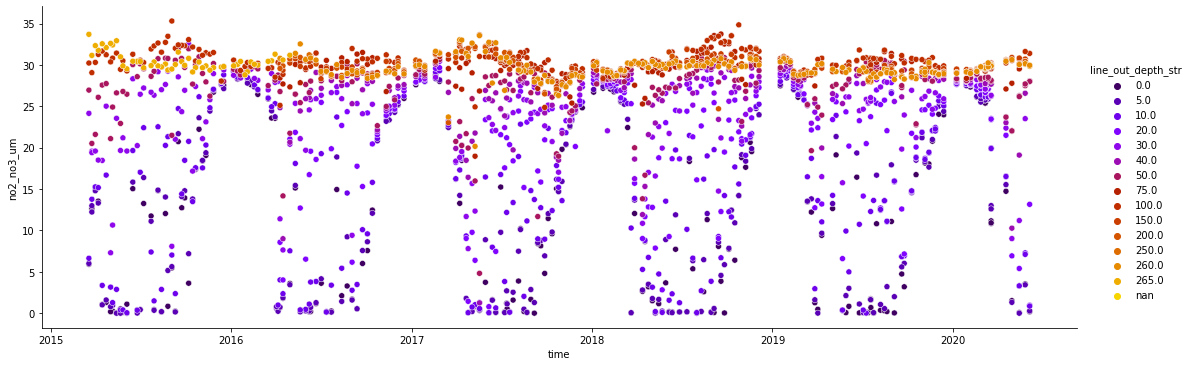

In [ ]:
sns.relplot(data=df.sort_values('line_out_depth'),x='time',y='no2_no3_um',hue='line_out_depth_str',aspect=3, markers='no2_no3_flag',palette='gnuplot')

In [ ]:
px.scatter(df.sort_values('line_out_depth'),x='time',y='po4',color='line_out_depth', hover_data=['hakai_id'], template='simple_white',title='PO4',labels={'po4':'PO4 (uM/L)', 'line_out_depth':'Bottle Target Depth (m)'})

In [ ]:
px.scatter(df[df['line_out_depth'].isin([150,200,260])],x='month',y='po4',color='year', hover_data=['hakai_id','date'], template='simple_white',title='PO4',labels={'po4':'PO4 (uM)', 'line_out_depth':'Bottle Target Depth (m)'},facet_row='line_out_depth')

## Contour plot

In [ ]:

# Plot contourf interpolate linearly over the x axis and maximum over two NaN values
var = 'no2_no3_um'
df_pivot = pd.pivot_table(df,values=var,index='line_out_depth',columns='time',aggfunc='mean').interpolate(axis=0,limit=2).sort_index(axis=0).sort_index(axis=1).interpolate(axis=1,limit=3)
fig = go.Figure(data =
    go.Contour(z=df_pivot.values,x=df_pivot.columns,y=df_pivot.index.values,
               colorbar=dict(title=var, titleside='right'),
               colorscale='RdYlGn',
               ncontours=10,
               contours_coloring='heatmap'
               #,connectgaps=True
              ))
fig.update_yaxes(title='Depth (m)',autorange="reversed",linecolor='black',mirror=True,
                 ticks='outside',showline=True)
fig.update_xaxes(linecolor='black',mirror=True,ticks='outside',showline=True)
fig.show()

## Scatter with colorbar

In [ ]:
## Scatter with colorbar
fig = px.scatter(df.dropna(subset=['no2_no3_um'],axis=0),x='time',y='depth',
                 color='no2_no3_um',color_continuous_scale='RdYlGn',
                 hover_name='hakai_id')
fig.update_yaxes(title='Depth (m)',autorange="reversed",linecolor='black',mirror=True,
                 ticks='outside')
fig.update_xaxes(linecolor='black',mirror=True,ticks='outside',showline=True)
fig.show()